# Data Analytics I: Assignment 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# extracting data from the csv
def extract_data(file):
    data = pd.read_csv(file)
    return data

data = extract_data('Electric_Vehicle_Data.csv')

In [3]:
# extracting the columns
data.columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

In [4]:
# step 1: Select the task-relevant data relation P.
# Make, Model, electric Vehicle Type,Electric Range,Base MSRP Model Year are what i want to select
data_reduced = data[['Make', 'Model', 'Electric Vehicle Type', 'Electric Range', 'Base MSRP', 'Model Year', "State"]]

In [5]:
data_reduced.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State
0,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),16,0,2017,WA
1,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),16,0,2018,WA
2,TESLA,MODEL S,Battery Electric Vehicle (BEV),210,0,2017,WA
3,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),25,0,2021,WA
4,TESLA,MODEL 3,Battery Electric Vehicle (BEV),308,0,2020,WA


In [6]:
def create_concept_hierarchy(data):
    concept_hierarchy = {}

    # Make
    makes = data['Make'].unique()
    concept_hierarchy['Make'] = {make: make for make in makes}
    # Electric Vehicle Type
    concept_hierarchy['Electric Vehicle Type'] = {
        'Battery Electric Vehicle (BEV)': 'FullElectric',
        'Plug-in Hybrid Electric Vehicle (PHEV)': 'HybridElectric'
    }

    # Electric Range
    concept_hierarchy['Electric Range'] = lambda x: 'LongRange' if x > 200 else ('MediumRange' if x > 100 else 'ShortRange')

    # Base MSRP
    concept_hierarchy['Base MSRP'] = lambda x: 'HighEnd' if x > 50000 else ('MidRange' if x > 30000 else 'Affordable')

    # Model Year
    concept_hierarchy['Model Year'] = lambda x: str(x // 10 * 10) + 's'  # Generalize to decades

    # State

    regions = {
        'West': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'CO', 'AZ', 'NM'],
        'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
        'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL'],
        'Northeast': ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'PA', 'NJ', 'DE', 'MD', 'DC']
    }
    concept_hierarchy['State'] = {state: region for region, states in regions.items() for state in states}

    return concept_hierarchy

hierarchy = create_concept_hierarchy(data_reduced)


In [7]:
# Print the concept hierarchy
for attribute, mapping in hierarchy.items():
    print(f"\n{attribute}:")
    if callable(mapping):
        print(f"  Custom function: {mapping.__name__}")
    else:
        for key, value in list(mapping.items())[:5]:  # Print first 5 items as an example
            print(f"  {key}: {value}")
        if len(mapping) > 5:
            print(f"  ... and {len(mapping) - 5} more")


Make:
  AUDI: AUDI
  TESLA: TESLA
  JEEP: JEEP
  CHEVROLET: CHEVROLET
  KIA: KIA
  ... and 35 more

Electric Vehicle Type:
  Battery Electric Vehicle (BEV): FullElectric
  Plug-in Hybrid Electric Vehicle (PHEV): HybridElectric

Electric Range:
  Custom function: <lambda>

Base MSRP:
  Custom function: <lambda>

Model Year:
  Custom function: <lambda>

State:
  WA: West
  OR: West
  CA: West
  NV: West
  ID: West
  ... and 44 more


In [8]:
def generalize_attributes(data, concept_hierarchy):
    generalized_data = data.copy()
    for column in data.columns:
        if column in concept_hierarchy:
            generalized_data[column] = data[column].map(concept_hierarchy[column])
    print("Size after generalization:", len(generalized_data))

    return generalized_data

generalized_data = generalize_attributes(data_reduced, hierarchy)

Size after generalization: 181458


In [9]:
generalized_data.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State
0,AUDI,A3,HybridElectric,ShortRange,Affordable,2010s,West
1,AUDI,A3,HybridElectric,ShortRange,Affordable,2010s,West
2,TESLA,MODEL S,FullElectric,LongRange,Affordable,2010s,West
3,JEEP,WRANGLER,HybridElectric,ShortRange,Affordable,2020s,West
4,TESLA,MODEL 3,FullElectric,LongRange,Affordable,2020s,West


In [16]:
# performing group by on the generalized data
grouped_data = generalized_data.groupby(['Make', 'Model', 'Electric Vehicle Type', 'Electric Range', 'Base MSRP', 'Model Year', "State"]).size().reset_index(name='Count')
grouped_data = grouped_data.sort_values(by='Count', ascending=False)
grouped_data.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State,Count
275,TESLA,MODEL Y,FullElectric,ShortRange,Affordable,2020s,West,34598
248,TESLA,MODEL 3,FullElectric,ShortRange,Affordable,2020s,West,16323
240,TESLA,MODEL 3,FullElectric,LongRange,Affordable,2010s,West,10174
207,NISSAN,LEAF,FullElectric,ShortRange,Affordable,2010s,West,6633
75,CHEVROLET,VOLT,HybridElectric,ShortRange,Affordable,2010s,West,4789


In [19]:
# group by make and count the number of vehicles
grouped_data_make = generalized_data.groupby(['Make']).size().reset_index(name='Count')
grouped_data_make = grouped_data_make.sort_values(by=['Count'], ascending=False)
grouped_data_make.head()

,Make,Count
34,TESLA,80819
27,NISSAN,14037
6,CHEVROLET,13864
11,FORD,9527
4,BMW,7680


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


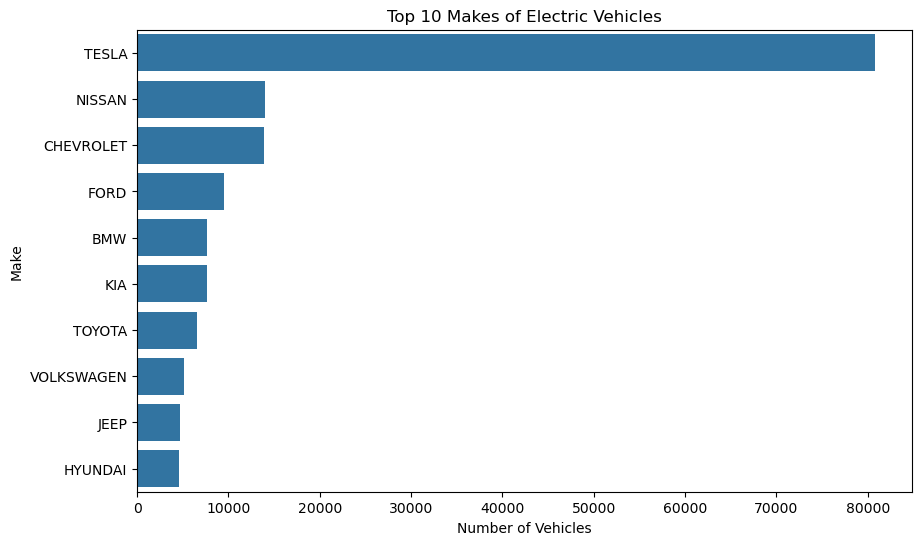

In [20]:
# visualising the data

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Make', data=grouped_data_make.head(10))
plt.title('Top 10 Makes of Electric Vehicles')
plt.xlabel('Number of Vehicles')
plt.ylabel('Make')
plt.show()


In [22]:
# grouping by electric vehicle type and count based on state
grouped_data_type = generalized_data.groupby(['Electric Vehicle Type', 'State']).size().reset_index(name='Count')
grouped_data_type = grouped_data_type.sort_values(by=['Count'], ascending=False)
grouped_data_type.head()


,Electric Vehicle Type,State,Count
3,FullElectric,West,141813
7,HybridElectric,West,39401
2,FullElectric,South,84
6,HybridElectric,South,46
1,FullElectric,Northeast,41


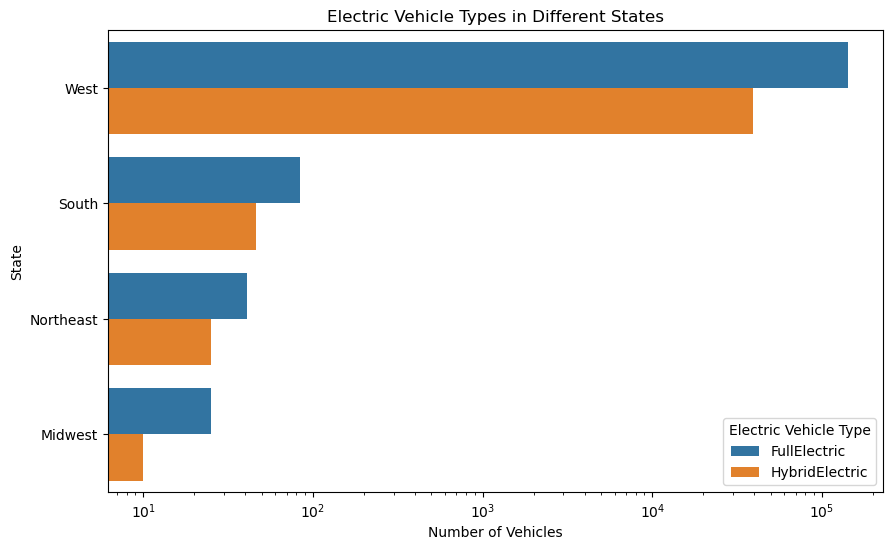

In [24]:
# plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='State', hue='Electric Vehicle Type', data=grouped_data_type)
plt.title('Electric Vehicle Types in Different States')
plt.xlabel('Number of Vehicles')
plt.ylabel('State')
plt.xscale('log')
plt.show()


In [25]:
# grouping by electric range and price 
grouped_data_range = generalized_data.groupby(['Electric Range', 'Base MSRP']).size().reset_index(name='Count')
grouped_data_range = grouped_data_range.sort_values(by=['Count'], ascending=False)
grouped_data_range.head()

,Electric Range,Base MSRP,Count
4,ShortRange,Affordable,142000
0,LongRange,Affordable,29637
2,MediumRange,Affordable,6509
1,LongRange,HighEnd,1523
6,ShortRange,MidRange,1039


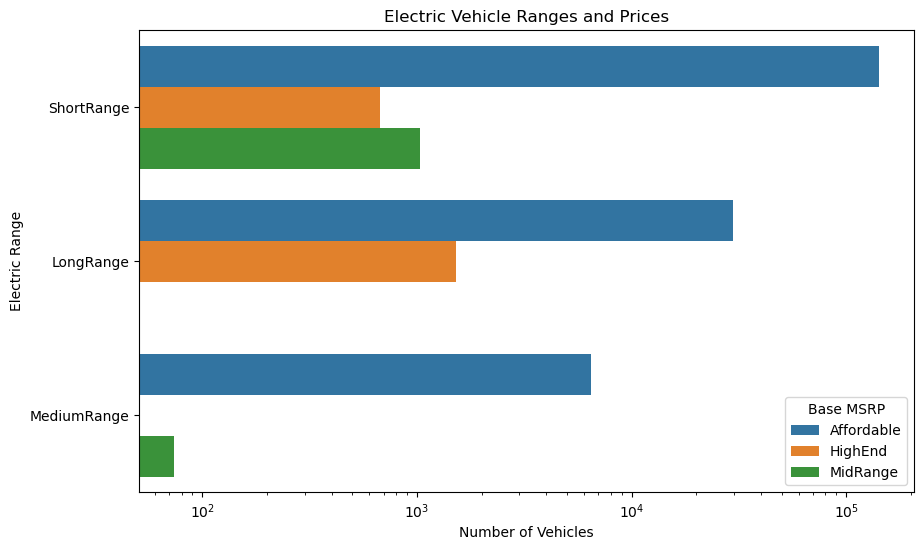

In [26]:
#  visualising the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Electric Range', hue='Base MSRP', data=grouped_data_range)
plt.title('Electric Vehicle Ranges and Prices')
plt.xlabel('Number of Vehicles')
plt.ylabel('Electric Range')
plt.xscale('log')
plt.show()


In [29]:
# grouping by model year, model and make
grouped_data_year = generalized_data.groupby(['Model Year', 'Make', 'Model']).size().reset_index(name='Count')
grouped_data_year = grouped_data_year.sort_values(by=['Count'], ascending=False)
grouped_data_year.head()


,Model Year,Make,Model,Count
164,2020s,TESLA,MODEL Y,37007
161,2020s,TESLA,MODEL 3,19953
52,2010s,TESLA,MODEL 3,10197
44,2010s,NISSAN,LEAF,10121
53,2010s,TESLA,MODEL S,5588


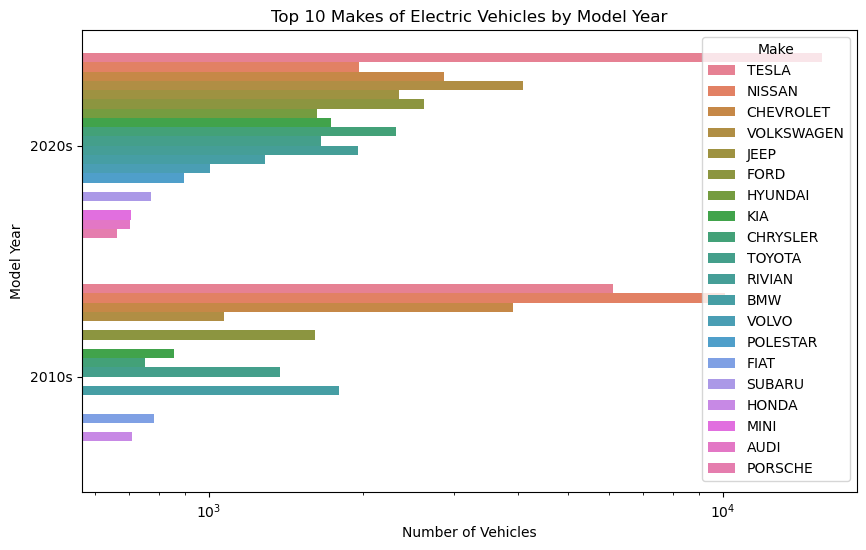

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Model Year', hue='Make', data=grouped_data_year.head(50), errorbar=None)
plt.title('Top 10 Makes of Electric Vehicles by Model Year')
plt.xlabel('Number of Vehicles')
plt.xscale('log')
plt.ylabel('Model Year')
plt.show()

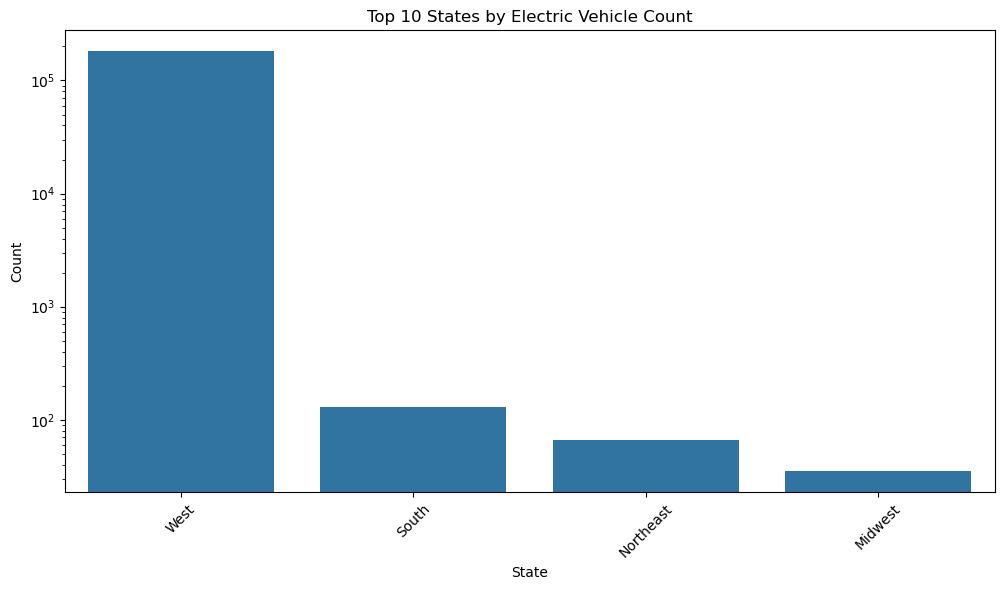

In [52]:
state_count = generalized_data.groupby('State').size().sort_values(ascending=False).reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Count', data=state_count.head(10))
plt.title('Top 10 States by Electric Vehicle Count')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

In [12]:
# from collections import Counter


# def attribute_oriented_induction(data, concept_hierarchy):


#     # Step 2: Perform attribute-oriented induction
#     generalized_data = generalize_attributes(data, concept_hierarchy)

#     # Step 3: Simplify the generalized relation
#     # simplified_data = simplify_relation(generalized_data)
#     # characteristic_rules = extract_rules(simplified_data)

#     return characteristic_rules, simplified_data

# def generalize_attributes(data, concept_hierarchy):
#     generalized_data = data.copy()
#     for column in data.columns:
#         if column in concept_hierarchy:
#             generalized_data[column] = data[column].map(concept_hierarchy[column])
#     print("Size after generalization:", len(generalized_data))

#     return generalized_data

# # def simplify_relation(data):
# #     # group by all columns except the last one
# #     grouped = data.groupby(data.columns[:-1].tolist(), as_index=False).agg({data.columns[-1]: set})
# #     simplified = grouped.copy()

# #     for column in data.columns[:-1]:
# #         if len(grouped[column].unique()) == 1:
# #             simplified = simplified.drop(column, axis=1)

# #     print("Size after simplification:", len(simplified))

# #     return simplified

# # def extract_rules(data, min_support=0.1, min_confidence=0.7):
# #     total_records = len(data)
# #     rules = []

# #     for column in data.columns[:-1]:  # Exclude the last column (which contains sets of values)
# #         value_counts = Counter(data[column])
        
# #         for value, count in value_counts.items():
# #             support = count / total_records
# #             if support >= min_support:
# #                 consequent_counts = Counter([item for items in data[data[column] == value][data.columns[-1]] for item in items])
                
# #                 for consequent, consequent_count in consequent_counts.items():
# #                     confidence = consequent_count / count
# #                     if confidence >= min_confidence:
# #                         rule = f"If {column} is {value}, then {data.columns[-1]} is likely to be {consequent}"
# #                         rules.append((rule, support, confidence))

# #     return rules

# # characteristic_rules, simplified_data = attribute_oriented_induction(data_reduced, hierarchy)

# print("Characteristic Rules:")
# for rule in characteristic_rules:
#     print(rule)

In [13]:

# def simplify_relation(data):
#     # group by all columns except the last one
#     grouped = data.groupby(data.columns[:-1].tolist(), as_index=False).agg({data.columns[-1]: set})
#     simplified = grouped.copy()

#     for column in data.columns[:-1]:
#         if len(grouped[column].unique()) == 1:
#             simplified = simplified.drop(column, axis=1)

#     print("Size after simplification:", len(simplified))

    # return simplified

# def extract_rules(data, min_support=0.1, min_confidence=0.7):
#     total_records = len(data)
#     rules = []

#     for column in data.columns[:-1]:  # Exclude the last column (which contains sets of values)
#         value_counts = Counter(data[column])
        
#         for value, count in value_counts.items():
#             support = count / total_records
#             if support >= min_support:
#                 consequent_counts = Counter([item for items in data[data[column] == value][data.columns[-1]] for item in items])
                
#                 for consequent, consequent_count in consequent_counts.items():
#                     confidence = consequent_count / count
#                     if confidence >= min_confidence:
#                         rule = f"If {column} is {value}, then {data.columns[-1]} is likely to be {consequent}"
#                         rules.append((rule, support, confidence))

#     return rules


In [14]:
simplified_data.head()

NameError: name 'simplified_data' is not defined

In [ ]:
# grouping by make and counting number of electric vehicles
make_counts = simplified_data.groupby('Make').size()
# sorting the values
make_counts = make_counts.sort_values(ascending=False)
# printing top 10
make_counts.head(10)


In [ ]:
# plotting the top 10 makes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
make_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Electric Vehicle Makes')
plt.xlabel('Make')
plt.ylabel('Number of Electric Vehicles')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_visualizations(simplified_data):
    # Set the style for all plots
    plt.style.use('seaborn')
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 3, figsize=(20, 15))
    fig.suptitle('Attribute-Oriented Induction Results', fontsize=16)
    
    # Flatten the axs array for easier indexing
    axs = axs.flatten()
    
    # List of columns to visualize
    columns_to_plot = ['Make', 'Electric Vehicle Type', 'Electric Range', 'Base MSRP', 'Model Year', 'State']
    
    for i, column in enumerate(columns_to_plot):
        # Count the occurrences of each category
        counts = simplified_data[column].value_counts()
        
        # Create a bar plot
        sns.barplot(x=counts.index, y=counts.values, ax=axs[i])
        
        # Customize the subplot
        axs[i].set_title(f'Distribution of {column}')
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Count')
        
        # Rotate x-axis labels if there are many categories
        if len(counts) > 5:
            axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Call the function with your simplified data
create_visualizations(simplified_data)


# Generalizing the rules
generalize_rules(rules)
print('Generalized rules:')
generate_rules(rules)

# Removing attributes
remove_attributes(rules, 'Vehicle')
print('Removed attributes:')
generate_rules(rules)

# Generating rules
print('Generated rules:')
generate_rules(rules)

# Evaluating the rules
print('Evaluated rules:')
evaluate_rules(rules)

# Extracting rules
rules = extract_rules(extract_data('Electric_Vehicle_Data.csv'))
print('Extracted rules:')
generate_rules(rules)
